In [200]:
import os
import numpy as np
import pandas as pd
from pandas.tseries.offsets import Day, Second
import sqlite3
import time
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
import matplotlib.dates as dates
%matplotlib inline

In [263]:
PLOT_WIDTH_PER_DAY = 1.5
PLOT_HEIGHT = 8.0
RESAMPLE = '6min'
CHUCK = 0
BED = 1
LOCAL_HOST_NAME = 'testing'
LOCAL_VAR_PATH = '../local/var/'

sensors = {CHUCK: {'temp': 1, 'light': 2, 'soil':3, 'dummy': 4, 'ds_temp':5},
           BED:   {'strain': 6, 'temp': 7, 'motion': 8}}

def spans(xlim):
    drs = pd.date_range(xlim[0], xlim[1], freq='D')
    return zip(drs, drs + pd.DateOffset(hour=8))

In [268]:
def plot(df, out='telemetry_all.png', weekly=False):
    df.sort_index(inplace=True)
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
    
    if weekly:
        ts = df.index[0]
        start = ts-Day(ts.dayofweek, normalize=True)
        end = start+Day(7)-Second(1)
    else:
        start = df.index[0].normalize()
        end = df.index[-1].normalize()+Day()
    delta = (end - start) / pd.Timedelta('1 Day')
    
    fig.set_size_inches(delta*PLOT_WIDTH_PER_DAY, PLOT_HEIGHT)
    fig.tight_layout()
    

    axes = list(ax)
    plot_bed(df, axes[0], xlim=(start, end))
    plot_chuck(df, axes[1], xlim=(start, end))
    
    # Save to file
    fig.savefig(os.path.join(LOCAL_VAR_PATH, out),
                transparent=False, bbox_inches='tight', pad_inches=.05)

In [332]:
def plot_bed(df, axes, xlim=None):
    ax_left = axes
    ax_right = axes.twinx()
    
    # Set of sensors in the dataset
    sids = set(df.sid)
    groups = df.groupby(['sid'])
    
    xlim = (df.index[0].normalize(), df.index[-1].normalize()+Day()) if xlim is None else xlim
    
    # BED: strain, motion & temp
    if sensors[BED]['strain'] in sids:
        groups.get_group(sensors[BED]['strain']).value.resample(RESAMPLE).mean() \
                         .plot(ax=ax_left, style='k', label=r'$m_{strain}$')
    if sensors[BED]['motion'] in sids:
        ax_left.eventplot(groups.get_group(sensors[BED]['motion']).value.index,
                          linewidths=.2, colors='b', linelengths=30, lineoffsets=700)
    if sensors[BED]['temp'] in sids:
        groups.get_group(sensors[BED]['temp']).value.resample(RESAMPLE).mean() \
                         .plot(ax=ax_right, style='r', label=r'$T_{bedroom}$')

    # Legend bed
    ep_artist = mpl_lines.Line2D([], [], color='b', label=r'motion')
    handles, labels = ax_left.get_legend_handles_labels()
    handles.append(ep_artist)
    handles_r, labels_r = ax_right.get_legend_handles_labels()
    if handles_r:
        legend_r = ax_right.legend(handles=handles_r, loc='upper right', shadow=True, fontsize='medium')
        ax_right.add_artist(legend_r)
    ax_right.legend(handles=handles, title='[Bed]', loc='upper left', shadow=True, fontsize='medium')
    
    # Left side
    ax_left.set_ylim((500, 800))
    ax_left.set_ylabel(u'Arbitrary ADC values')
    ax_left.set_yticks([])
    
    # Right side
    ax_right.set_ylim((15, 35))
    ax_right.set_ylabel(u'Temperature (°C)')
    ax_right.yaxis.grid(True)
    
    # shade 0-8 am
    for span in spans(xlim):
        ax_right.axvspan(span[0], span[1], facecolor='0.2', alpha=0.1)
        
    ts = pd.Timestamp.now().tz_localize('Europe/Amsterdam')
    if xlim[0] < ts and xlim[1] >= ts:
        ax_left.axvline(ts, linestyle='--', color='k')
    
def plot_chuck(df, axes, xlim=None):
    ax_left = axes
    ax_right = axes.twinx()
    
    # Set of sensors in the dataset
    sids = set(df.sid)
    groups = df.groupby(['sid'])
    
    xlim = (df.index[0].normalize(), df.index[-1].normalize()+Day()) if xlim is None else xlim

    
    # CHUCK: soil, light, temp, ds_temp
    if sensors[CHUCK]['ds_temp'] in sids:
        groups.get_group(sensors[CHUCK]['ds_temp']).value.resample(RESAMPLE).mean() \
                        .plot(ax=ax_right, style='r', label=r'$T_{desk}$')
    if sensors[CHUCK]['light'] in sids:
        groups.get_group(sensors[CHUCK]['light']).value.resample(RESAMPLE).mean() \
                        .plot(ax=ax_left, style='g', label="$lum_{chuck}$")
    if sensors[CHUCK]['soil'] in sids:
        groups.get_group(sensors[CHUCK]['soil']).value.resample(RESAMPLE).mean().bfill() \
                        .plot(ax=ax_left, style='b', label=r"$moisture_{soil}$")
    # if sensors[CHUCK]['temp'] in sids:
    # groups.get_group(sensors[CHUCK]['temp']).value.resample(RESAMPLE).mean().bfill().plot(ax=ax_left, style='y', label=r"$moisture_{soil}$")

    # Legend
    handles, labels = ax_left.get_legend_handles_labels()
    handles_r, labels_r = ax_right.get_legend_handles_labels()
    if handles_r:
        legend_r = ax_right.legend(handles=handles_r, loc='upper right', shadow=True, fontsize='medium')
        ax_right.add_artist(legend_r)
    ax_right.legend(handles=handles, title='[Chuck]', loc='upper left', shadow=True, fontsize='medium')

    # Left side
    ax_left.set_ylim((0, 1023))
    ax_left.set_ylabel(u'Arbitrary ADC values')
    ax_left.set_yticks([])

    # Right side
    ax_right.set_ylim((15, 35))
    ax_right.set_ylabel(u'Temperature (°C)')
    ax_right.yaxis.grid(True)
    
    # shade 0-8 am
    for span in spans(xlim):
        ax_right.axvspan(span[0], span[1], facecolor='0.2', alpha=0.1)
    
    ax_left.set_xlim(xlim)
    ax_left.set_xlabel('')
    #ax_left.set_xticks(pd.date_range(xlim[0], xlim[1]))
    #ax_left.set_xticklabels(['a' for n in pd.date_range(xlim[0], xlim[1])], rotation=0)
    ax_left.set_xticks([])
    ax = ax_left
    ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0, 1, 2, 3, 4, 5, 6, 7),
                                                    interval=1))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))

    # FIXME: Can be tweaked further to move to center
    ax.xaxis.set_major_locator(dates.WeekdayLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%b %Y'))
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=0, fontsize=10)
    
    ax_left.annotate('{hostname}, {timestamp}'
                       .format(hostname=LOCAL_HOST_NAME,
                               timestamp=pd.Timestamp.now(),),
                       xy=(1, 0), xycoords='axes fraction', fontsize=10, xytext=(0, -35),
                       textcoords='offset points', ha='right', va='top')
    
    ts = pd.Timestamp.now().tz_localize('Europe/Amsterdam')
    if xlim[0] < ts and xlim[1] >= ts:
        ax_left.axvline(ts, linestyle='--', color='k')

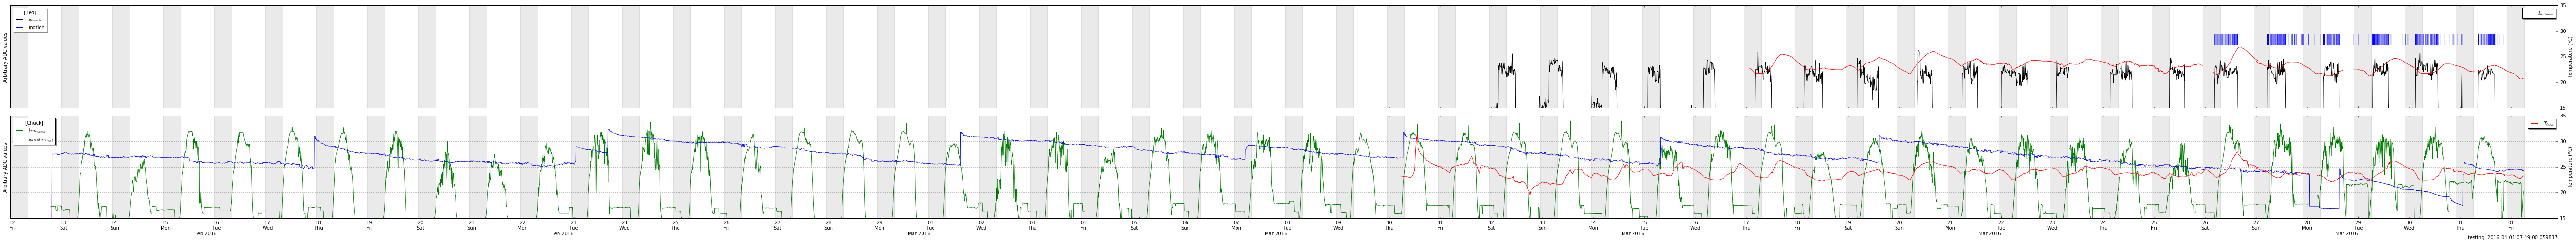

In [333]:
plot(pd.read_hdf('../local/db/telemetry.h5', 'data').tz_localize('UTC').tz_convert('Europe/Amsterdam'))

## Weekly plots


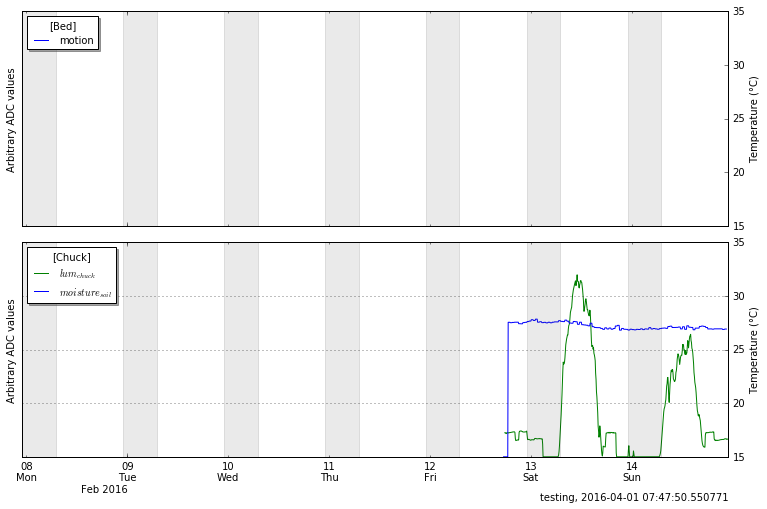

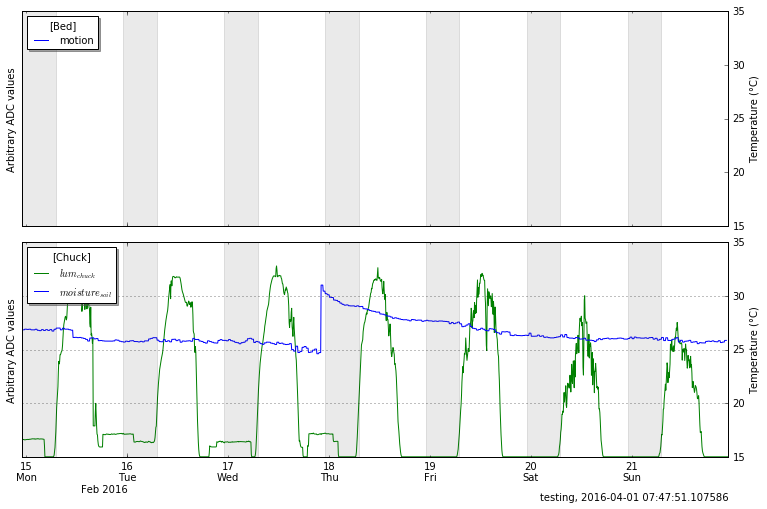

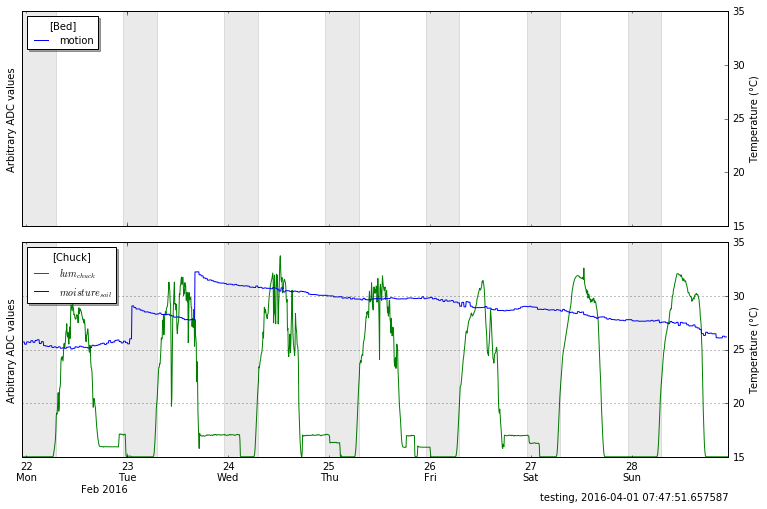

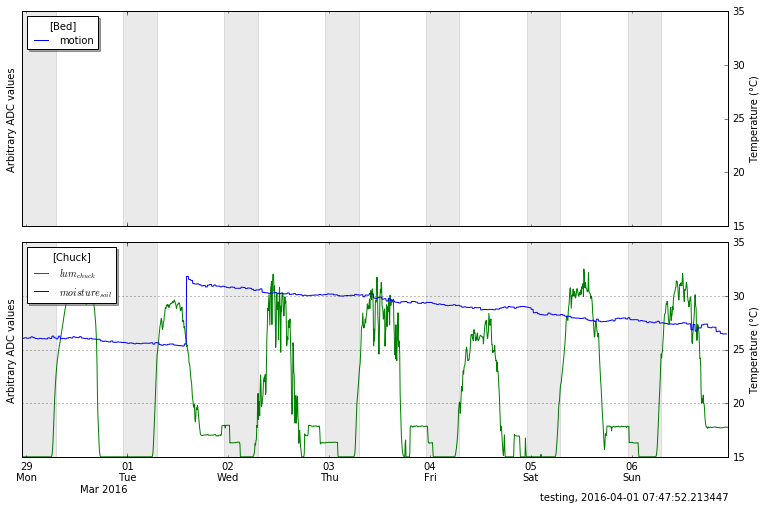

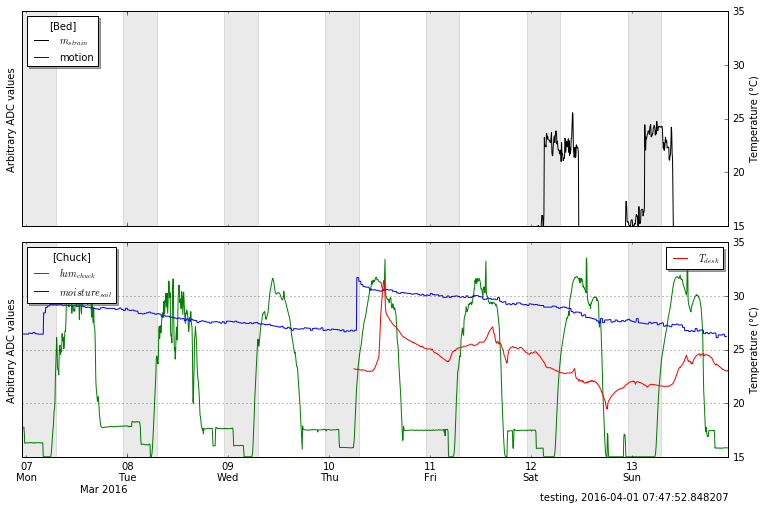

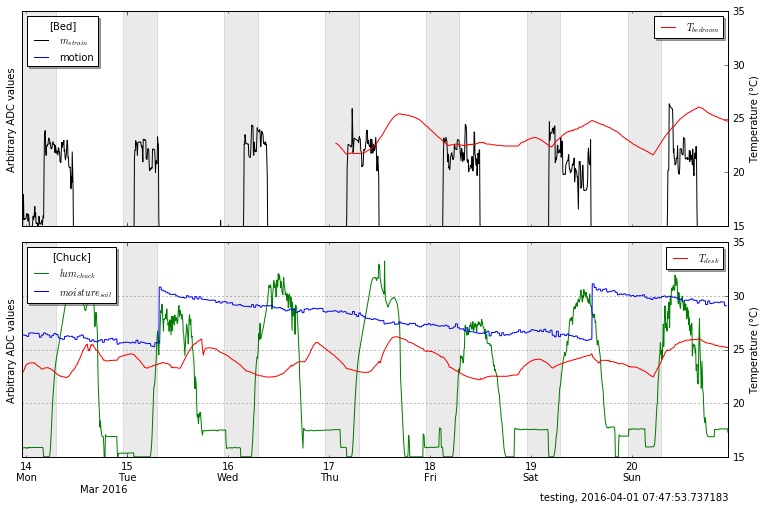

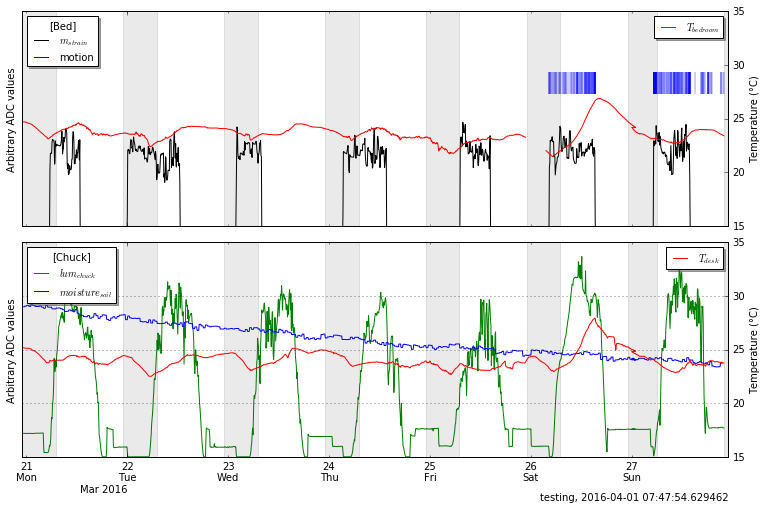

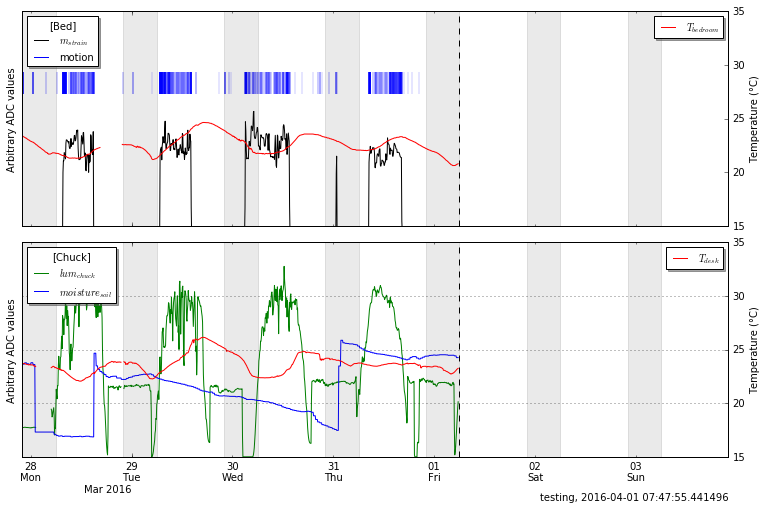

In [329]:
# df = df.loc[df.nid == 0]
# last_bed_row = df.index[-1]
# start, end = df.index[[0, -1]]
# print start, "to",  end
df = pd.read_hdf('../local/db/telemetry.h5', 'data').tz_localize('UTC').tz_convert('Europe/Amsterdam')
df.sort_index(inplace=True)
grouped = df.groupby(df.index.week)
for g in groups:
    plot(grouped.get_group(g), out='telemetry-2016_w{}.png'.format(g), weekly=True)

In [280]:
df = pd.read_hdf('../local/db/telemetry.h5', 'data').tz_localize('UTC').tz_convert('Europe/Amsterdam')
df.sort_index(inplace=True)
grouped = df.groupby(df.index.week)
%time grouped.groups.keys()[-1]
%timeit max(set(df.index.week))

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.28 s
10 loops, best of 3: 22.9 ms per loop
